# Fitting a GP to the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import george
import sigma_clip as sc

Start with Praesepe in 1-D.

In [2]:
pr = pd.read_csv("../data/praesepe_gaia.csv")

Text(0, 0.5, 'Prot')

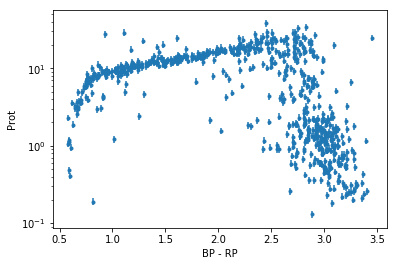

In [3]:
yerr = pr.period.values * .1
m = np.isfinite(pr.bprp.values) * np.isfinite(pr.period.values) * np.isfinite(yerr)
x, y, yerr = pr.bprp.values[m], pr.period.values[m], yerr[m]
m = np.argsort(x)
x, y, yerr = x[m], y[m], yerr[m]
data = (x, y, yerr)

plt.errorbar(x, y, yerr=yerr, fmt=".")
plt.yscale("log")
plt.xlabel("BP - RP")
plt.ylabel("Prot")

Sigma clip.

100%|██████████| 1/1 [00:00<00:00, 331.02it/s]


Text(0, 0.5, 'Prot')

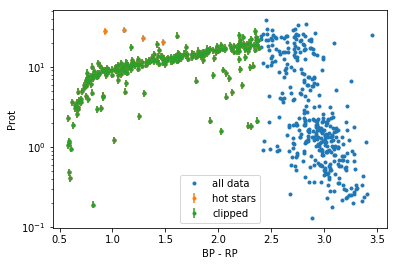

In [6]:
# y_clipped, mask = sc.running_sigma_clip(.2, x, np.log10(y))
# mask = sc.running_sigma_clip(20, x[m], np.log10(y[m]), 2)
# _, mask = sc.interval_sigma_clip(.2, x[m], np.log10(y[m]), 2)
# _, mask = sc.sigma_clip(np.log10(y[m]), 2)

m = (x < 2.4)
s = 1.9e4
# len(x[m])*34
plt.plot(x, y, ".", label="all data")
# mask, spl = sc.spline_sigma_clip(x[m], y[m], s, sigma=2.5)
mask = sc.interval_sigma_clip(1, x[m], y[m])

plt.errorbar(x[m], y[m], yerr=yerr[m], fmt=".", label="hot stars")
plt.errorbar(x[m][mask], y[m][mask], yerr=yerr[m][mask], fmt=".", label="clipped")

# plt.plot(x[m], spl(x[m]), "k", label="spline fit", zorder=10)

plt.legend()

plt.yscale("log")
plt.xlabel("BP - RP")
plt.ylabel("Prot")

In [64]:
import george
from george import kernels

def lnlike(p, t, y, yerr):
    a, tau = np.exp(p[:2])
    gp = george.GP(a * kernels.Matern32Kernel(tau))
    gp.compute(t, yerr)
    return gp.lnlikelihood(y)

def lnprior(p):
    lna, lntau = p
    if (-5 < lna < 5 and  -5 < lntau < 5):
        return 0.0
    return -np.inf

def lnprob(p, x, y, yerr):
    lp = lnprior(p)
    return lp + lnlike(p, x, y, yerr) if np.isfinite(lp) else -np.inf

In [65]:
initial = np.array([0, 0])
ndim = len(initial)
p0 = [np.array(initial) + 1e-8 * np.random.randn(ndim)
      for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data);

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, 1000, progress=True);
sampler.reset();

print("Running production...")
sampler.run_mcmc(p0, 2000, progress=True);

Running burn-in...
Running production...


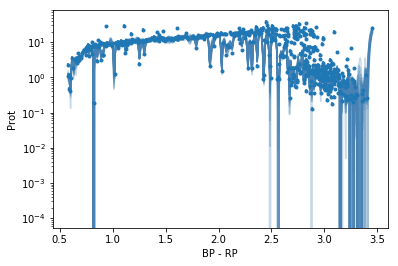

In [70]:
# Plot the data.
x, y, yerr = pr.bprp.values[m], pr.period.values[m], yerr[m]
plt.errorbar(x, y, yerr=yerr, fmt=".")
plt.yscale("log")
plt.xlabel("BP - RP")
plt.ylabel("Prot")

# The positions where the prediction should be computed.
xs = np.linspace(min(x), max(x), 500)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    # Set up the GP for this sample.
    a, tau = np.exp(s[:2])
    gp = george.GP(a * kernels.Matern32Kernel(tau))
    gp.compute(x, yerr)

    # Compute the prediction conditioned on the observations and plot it.
    m = gp.sample_conditional(y, xs)
    pl.plot(xs, m, color="#4682b4", alpha=0.3)

In [17]:
import numpy as np

def model1(params, t):
    m, b, amp, loc, sig2 = params
    return m*t + b + amp * np.exp(-0.5 * (t - loc) ** 2 / sig2)

def lnlike1(p, t, y, yerr):
    return -0.5 * np.sum(((y - model1(p, t))/yerr) ** 2)

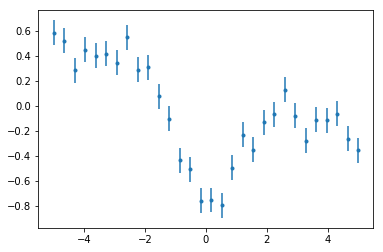

In [45]:
x = np.linspace(-5, 5, 30)
y = model1([-.08, .2, -1, 0, 1], x)
err = .1
yerr = np.ones_like(x)*err
y += np.random.randn(len(x))*err

plt.errorbar(x, y, yerr, fmt=".")

data = (x, y, yerr)

In [47]:
import george
from george import kernels

def model2(params, t):
    _, _, amp, loc, sig2 = params
    return amp * np.exp(-0.5 * (t - loc) ** 2 / sig2)

def lnlike2(p, t, y, yerr):
    a, tau = np.exp(p[:2])
    gp = george.GP(a * kernels.Matern32Kernel(tau))
    gp.compute(t, yerr)
    return gp.lnlikelihood(y - model2(p, t))

def lnprior2(p):
    lna, lntau, amp, loc, sig2 = p
    if (-5 < lna < 5 and  -5 < lntau < 5 and -10 < amp < 10 and
            -5 < loc < 5 and 0 < sig2 < 3):
        return 0.0
    return -np.inf

def lnprob2(p, x, y, yerr):
    lp = lnprior2(p)
    return lp + lnlike2(p, x, y, yerr) if np.isfinite(lp) else -np.inf

In [51]:
initial = np.array([0, 0, -1.0, 0.1, 0.4])
ndim = len(initial)
p0 = [np.array(initial) + 1e-8 * np.random.randn(ndim)
      for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, args=data);

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, 1000);
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 2000);

Running second burn-in...
Running production...


(30,) (30,)


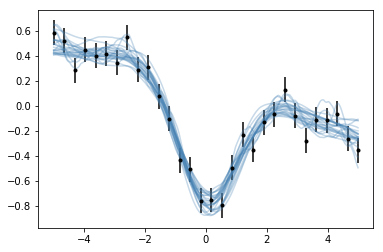

In [53]:
# Plot the data.
print(np.shape(x), np.shape(y))
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)

# The positions where the prediction should be computed.
xs = np.linspace(-5, 5, 500)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    # Set up the GP for this sample.
    a, tau = np.exp(s[:2])
    gp = george.GP(a * kernels.Matern32Kernel(tau))
    gp.compute(x, yerr)

    # Compute the prediction conditioned on the observations and plot it.
    m = gp.sample_conditional(y - model2(s, x), xs) + model2(s, xs)
    pl.plot(xs, m, color="#4682b4", alpha=0.3)